In [1]:
import pandas as pd

# Laad de annotaties
annotations_path = 'Data/input/annotaties_handmatig.csv'
annotations_df = pd.read_csv(annotations_path)

# Toon de kolomnamen van de annotaties
print(annotations_df.columns)

# Toon de eerste paar rijen van de annotaties om te controleren of alles correct is geladen
annotations_df.head()


Index(['label_name', 'bbox_x', 'bbox_y', 'bbox_width', 'bbox_height',
       'image_name', 'image_width', 'image_height'],
      dtype='object')


,label_name,bbox_x,bbox_y,bbox_width,bbox_height,image_name,image_width,image_height
0,Insect,26,25,86,85,112_20200616025701_33817.jpg,128,128
1,Insect,31,48,81,40,112_20200617003854_2710_t.jpg,128,128
2,Insect,49,32,57,55,120_20200729015043_808_t.jpg,128,128
3,Insect,41,33,54,35,121_20200527030132_39361.jpg,128,128
4,Insect,42,16,61,102,124_20200808005124_25555.jpg,128,128


Initial accuracy: 1.0


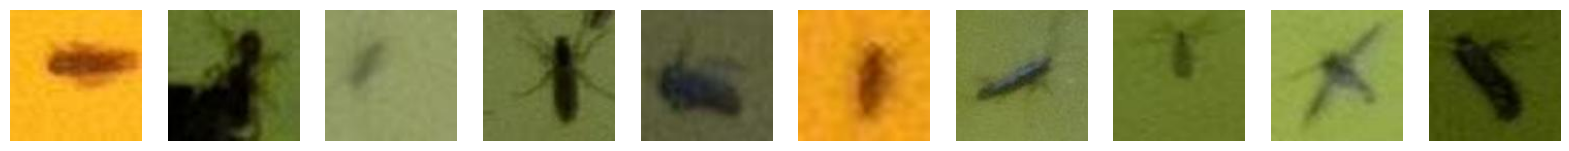

In [2]:
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Functie om afbeeldingen en labels te laden
def load_images_and_labels(df, images_dir):
    images = []
    labels = []
    for index, row in df.iterrows():
        img_path = os.path.join(images_dir, row['image_name'])  # gebruik de juiste kolomnaam
        image = Image.open(img_path).convert('RGB')
        images.append(np.array(image))
        labels.append(row['label_name'])
    return np.array(images), np.array(labels)

# Split de data in een initiële trainingsset en een set voor actieve selectie
initial_train_df, pool_df = train_test_split(annotations_df, test_size=0.95, random_state=42)

# Laad de initiële trainings- en pool-sets
images_dir = 'Data/input/images_resized'
initial_train_images, initial_train_labels = load_images_and_labels(initial_train_df, images_dir)
pool_images, pool_labels = load_images_and_labels(pool_df, images_dir)

# Train een initiële classifier
clf = RandomForestClassifier()
clf.fit(initial_train_images.reshape(len(initial_train_images), -1), initial_train_labels)

# Evaluatie van het model op de pool set
pool_predictions = clf.predict(pool_images.reshape(len(pool_images), -1))
print(f"Initial accuracy: {accuracy_score(pool_labels, pool_predictions)}")

# Selecteer de meest onzekere voorbeelden voor annotatie (bijv. met de laagste voorspelde waarschijnlijkheid)
probs = clf.predict_proba(pool_images.reshape(len(pool_images), -1))
uncertainty = 1 - np.max(probs, axis=1)
most_uncertain_indices = np.argsort(uncertainty)[-10:]  # Selecteer de top 10 meest onzekere voorbeelden

# Toon de geselecteerde voorbeelden voor handmatige annotatie naast elkaar
def show_selected_images(images, indices):
    num_images = len(indices)
    fig, axs = plt.subplots(1, num_images, figsize=(20, 5))
    for i, idx in enumerate(indices):
        axs[i].imshow(images[idx])
        axs[i].axis('off')
    plt.show()

# Toon de geselecteerde voorbeelden naast elkaar
show_selected_images(pool_images, most_uncertain_indices)


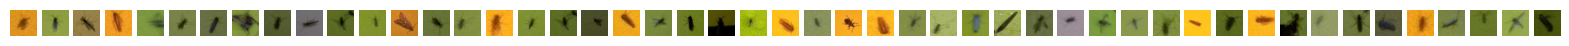

No more samples to evaluate in the pool set after iteration 1.
No more samples to select from in the pool set after 1 iterations.


In [3]:
# Functie om iteratief actieve leerstappen uit te voeren
def active_learning_iteration(train_images, train_labels, pool_images, pool_labels, num_iterations=10, num_samples=50):
    for i in range(num_iterations):
        if len(pool_images) == 0:
            print(f"No more samples to select from in the pool set after {i} iterations.")
            break
        
        # Train het model
        clf.fit(train_images.reshape(len(train_images), -1), train_labels)
        
        # Voorspel op de pool set en selecteer de meest onzekere voorbeelden
        probs = clf.predict_proba(pool_images.reshape(len(pool_images), -1))
        uncertainty = 1 - np.max(probs, axis=1)
        most_uncertain_indices = np.argsort(uncertainty)[-num_samples:]
        
        # Toon de geselecteerde voorbeelden naast elkaar
        show_selected_images(pool_images, most_uncertain_indices)
        
        # Voeg de geselecteerde voorbeelden toe aan de trainingsset
        train_images = np.concatenate((train_images, pool_images[most_uncertain_indices]), axis=0)
        train_labels = np.concatenate((train_labels, pool_labels[most_uncertain_indices]), axis=0)
        
        # Verwijder de geselecteerde voorbeelden uit de pool set
        pool_images = np.delete(pool_images, most_uncertain_indices, axis=0)
        pool_labels = np.delete(pool_labels, most_uncertain_indices, axis=0)
        
        # Evaluatie van het model
        if len(pool_images) > 0:
            pool_predictions = clf.predict(pool_images.reshape(len(pool_images), -1))
            print(f"Iteration {i+1}, accuracy: {accuracy_score(pool_labels, pool_predictions)}")
        else:
            print(f"No more samples to evaluate in the pool set after iteration {i+1}.")

# Start de actieve leer iteraties met meer voorbeelden per iteratie
active_learning_iteration(initial_train_images, initial_train_labels, pool_images, pool_labels)

In [4]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
import torchvision
from torchvision.transforms import functional as F
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

# Functie om bounding boxes te voorspellen met Faster R-CNN
def predict_bounding_boxes(images, model, device):
    model.eval()
    with torch.no_grad():
        predictions = model([F.to_tensor(image).to(device) for image in images])
    return [prediction['boxes'].cpu().numpy() for prediction in predictions]

# Functie om één afbeelding en annotaties te verwerken
def process_single_image(filename, image_dir, model, device):
    image_path = os.path.join(image_dir, filename)
    image = Image.open(image_path).convert('RGB')
    bounding_boxes = predict_bounding_boxes([np.array(image)], model, device)[0]
    annotations = [[filename, *box] for box in bounding_boxes]
    return annotations

# Functie om afbeeldingen en annotaties te verwerken met multi-threading
def annotate_images(image_dir, model, output_csv, device, num_workers=4):
    annotations = []
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = [executor.submit(process_single_image, filename, image_dir, model, device) for filename in image_files]
        for future in tqdm(futures, desc="Annotating images", total=len(image_files)):
            annotations.extend(future.result())
    
    # Sla de annotaties op in een CSV-bestand
    df = pd.DataFrame(annotations, columns=['filename', 'x1', 'y1', 'x2', 'y2'])
    df.to_csv(output_csv, index=False)

# Controleer of CPU beschikbaar is en stel het apparaat in
device = torch.device('cpu')

# Laad een pre-trained Faster R-CNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model = model.to(device)  # Verplaats het model naar de juiste device (CPU)

# Specificeer de paden
image_dir = 'Data/input/images_resized'
output_csv = 'annotated_images.csv'

# Annotateer de afbeeldingen
annotate_images(image_dir, model, output_csv, device, num_workers=4)


c:\Users\Gebruiker\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Gebruiker\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Annotating images:   0%|          | 16/39445 [00:30<20:46:24,  1.90s/it]
